In [28]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from costs import *
from grid_search import *
import math


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Least squares and linear basis functions models
## Least squares

In [20]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    #Solve as Ax = b
    A = np.transpose(tx).dot(tx)
    b = np.transpose(tx).dot(y)
    w_opt = np.linalg.solve(A,b)
    
    loss = compute_loss(y, tx, w_opt)
    
    return loss, w_opt
        

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [21]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    # least square or grid search
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    
    ls_loss, ls_w_opt = least_squares(y, tx)
    print("LSE", ls_loss, ls_w_opt)
    
    w0, w1 = generate_w(100)
    gs_losses = grid_search(y, tx, w0, w1)
    gs_loss, w0_opt, w1_opt = get_best_parameters(w0, w1, gs_losses)
    
    print("Grid Search:", gs_loss, "[", w0_opt, w1_opt, "]")
    
test_your_least_squares()

LSE 15.3858878688 [ 73.293922    13.47971243]
Grid Search: 15.5587033686 [ 72.7272727273 13.6363636364 ]


## Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [74]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [75]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    phi = np.zeros((x.shape[0], degree+1))
    powers = np.arange(degree+1)[np.newaxis]
    phi = np.power(x[:,np.newaxis], powers)    
    return phi

In [76]:
# Check
a = np.array([[1],[2],[3],[4]])
build_poly(a, 5)

array([[[   1,    1,    1,    1,    1,    1]],

       [[   1,    2,    4,    8,   16,   32]],

       [[   1,    3,    9,   27,   81,  243]],

       [[   1,    4,   16,   64,  256, 1024]]])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737467
Processing 3th experiment, degree=7, rmse=0.2496587036090727
Processing 4th experiment, degree=12, rmse=0.24349809575326772


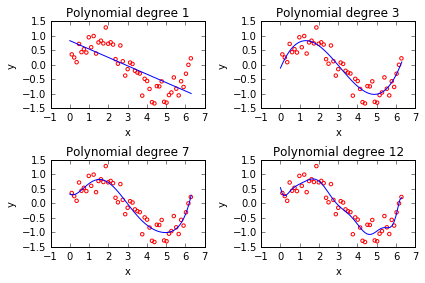

In [77]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        
        # form the data to do polynomial regression.
        phi = build_poly(x, degree)
        
        # least square and calculate rmse
        # Compute optimal value of w according to LSE
        mse, w_lse_opt = least_squares(y, phi)
        rmse = np.sqrt(2*mse)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, w_lse_opt, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()


polynomial_regression()

# Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [79]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # Set seed
    np.random.seed(seed)

    # Get size of the training set
    count_training = math.ceil(len(y) * ratio)
    
    # Get indices from 0 to N in randomized order
    indices = np.random.permutation(len(y))
    
    # The first count_training elements of indices are for training set
    # The remaining is for test set
    training_indice, test_indice = indices[:count_training], indices[count_training:]
    
    # Use the splitted indices to split the data for both x and y
    x_training, x_test = x[training_indice], x[test_indice]
    y_training, y_test = y[training_indice], y[test_indice]
    
    return x_training, y_training, x_test, y_test

Then, test your `split_data` function below.

In [80]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_training, y_training, x_test, y_test = split_data(x, y, ratio, seed)
    
    # ***************************************************
    # form train and test data with polynomial basis function
    # ***************************************************
    phi_training = build_poly(x_training, degree)
    phi_test = build_poly(x_test, degree)
    
    # ***************************************************
    # calcualte weight through least square.
    # ***************************************************
    loss_tr, w_lse_opt = least_squares(y_training, phi_training)
    
    # ***************************************************
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    # ***************************************************
    rmse_tr = np.sqrt(2*loss_tr)     
    rmse_te = np.sqrt(2* compute_loss(y_test, phi_test, w_lse_opt))     
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.253
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.607
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=1.985
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=5.692


# Ridge Regression
Please fill in the function below.

In [92]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    # Get w solving Ax = b
    A = np.transpose(tx).dot(tx) + 2*lamb*len(y)*np.identity(tx.shape[1])
    b = np.transpose(tx).dot(y)
    w_opt = np.linalg.solve(A, b)
    
    loss = compute_loss(y, tx, w_opt)
    
    return loss, w_opt

In [103]:
def test_your_ridge_regression():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    loss, w_opt = ridge_regression(y, tx, 0)
    rmse = np.sqrt(2*loss)
    
    print("Ridge", rmse, loss, w_opt) # Correspond to grid_search, Gradient Descent and Stochastic Gradient Descent

test_your_ridge_regression()

#LSE (15.385887868829398, array([ 73.293922  ,  13.47971243]))
#Ridge (15.385887868829403, array([ 73.293922  ,  13.47971243]))

Ridge 5.54723135786 15.3858878688 [ 73.293922    13.47971243]


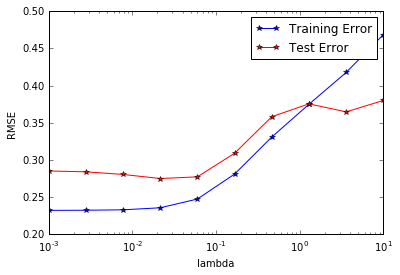

In [104]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-3, 1, 10)    
    
    # split the data, and return train and test data
    x_training, y_training, x_test, y_test = split_data(x, y, ratio, seed)
    
    # form train and test data with polynomial basis function
    phi_training = build_poly(x_training, degree)
    phi_test = build_poly(x_test, degree)
    
    # ridge regression with different lambda
    results_training = np.zeros((len(lambdas), 1))
    results_test = np.zeros((len(lambdas), 1))
    for i in range(0,len(lambdas)):
        loss_tr, w_opt = ridge_regression(y_training, phi_training, lambdas[i])
        results_training[i,0] = np.sqrt(2*loss_tr)
        results_test[i,0] = np.sqrt(2*compute_loss(y_test, phi_test, w_opt))

    plt.plot(lambdas, results_training[:,0], 'b-*', lambdas, results_test[:,0], 'r-*')
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('RMSE')
    plt.legend(['Training Error', 'Test Error'])
    plt.show()

seed = 6
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)